# Pulling Mr.Beast Video Data

In [1]:
%load_ext lab_black

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
import sys
import plotly_express as px
import urllib.request

sys.path.append("../src/")
from yt_pullers import get_search_results, get_video_stats

In [3]:
with open("../apikey/youtube.key") as f:
    youTubeApiKey = f.read()
# youTubeApiKey = _ #Read here
youtube = build("youtube", "v3", developerKey=youTubeApiKey)

In [4]:
mr_beast_id = "UCX6OQ3DkcsbYNE6H8uQQuVA"

In [5]:
df = get_search_results(query="", channel_id=mr_beast_id, youtube=youtube)

 20%|██        | 4/20 [00:01<00:05,  3.19it/s]


In [72]:
df_stats = get_video_stats(df, youtube)

In [73]:
df_stats["publishedAt"] = pd.to_datetime(df_stats["publishedAt"])

In [78]:
df_stats["publishTime"] = pd.to_datetime(df_stats["publishTime"])
df_stats["duration"] = df_stats["contentDetails.duration"].apply(pd.Timedelta)
df_stats["duration_seconds"] = (
    df_stats["duration"].astype("timedelta64[s]").fillna(0).astype("int")
)

In [79]:
KEEP_COLS = [
    "id",
    "title",
    "description",
    # "publishedAt",
    "publishTime",
    "kind_stats",
    "duration_seconds",
    "statistics.viewCount",
    "statistics.likeCount",
    # "statistics.favoriteCount",
    "statistics.commentCount",
    "thumbnails.default.url",
    "thumbnails.default.width",
    "thumbnails.default.height",
    "thumbnails.medium.url",
    "thumbnails.medium.width",
    "thumbnails.medium.height",
    "thumbnails.high.url",
    "thumbnails.high.width",
    "thumbnails.high.height",
    "contentDetails.duration",
    "contentDetails.dimension",
    "topicDetails.topicCategories",
    "snippet.defaultLanguage",
    "localizations.en.title",
    "localizations.en.description",
    "snippet.tags",
    "contentDetails.contentRating.ytRating",
]

In [80]:
df_final = df_stats[KEEP_COLS].copy()

In [81]:
df_final = df_final.rename(
    columns={
        "statistics.viewCount": "viewCount",
        "statistics.likeCount": "likeCount",
        "statistics.favoriteCount": "favoriteCount",
        "statistics.commentCount": "commentCount",
    }
).copy()

In [82]:
df_final["likeCount"] = pd.to_numeric(df_final["likeCount"])
df_final["viewCount"] = pd.to_numeric(df_final["viewCount"])
df_final["commentCount"] = pd.to_numeric(df_final["commentCount"])

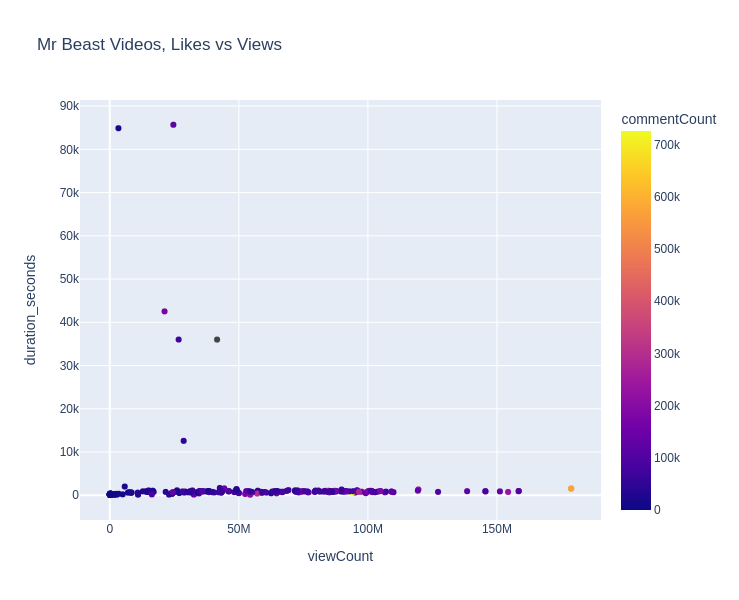

In [85]:
px.scatter(
    data_frame=df_final,
    x="viewCount",
    y="duration_seconds",
    color="commentCount",
    height=600,
    width=800,
    hover_data=["title"],
    title="Mr Beast Videos, Likes vs Views",
)

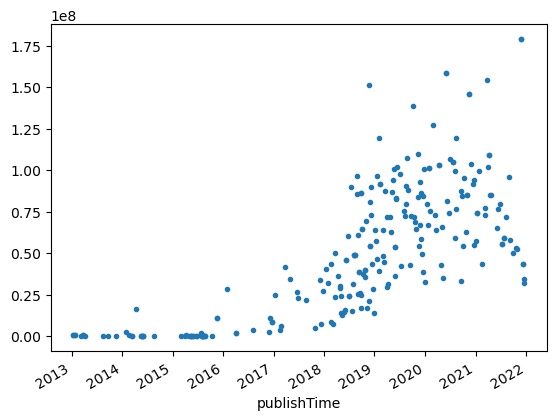

In [92]:
ax = df_final.set_index("publishTime")["viewCount"].plot(style=".")
plt.show()

In [108]:
channelTitle = df["channelTitle"].values[0]

In [124]:
df_final.to_csv(f"../out/{channelTitle}/{channelTitle}_youtube_stats.csv", index=False)

# Pull Video Thumbnails?

In [125]:
# !wget https://i.ytimg.com/vi/TQHEJj68Jew/hqdefault.jpg

In [131]:
for i, d in df_final.dropna(subset=["thumbnails.high.url"]).iterrows():
    myurl = d["thumbnails.high.url"]
    videoId = d["id"]
    urllib.request.urlretrieve(myurl, f"../out/{channelTitle}/thumbnails/{videoId}.jpg")